In [1276]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from scipy.stats import norm
from sklearn.metrics import r2_score

In [1277]:
# Laste poll-of-polls data
df = pd.read_csv("../data/v2_data_august.csv", sep=",")

In [1278]:
df

,Mnd,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,...,Rodt_reg_lag3,Rodt_reg_lag6,Andre_reg_lag3,Andre_reg_lag6,ledighet,ledig_trend3,ledig_trend6,styringsrente,styringsrente_trend3,styringsrente_trend6
0,1/31/2008,29.3,17.2,23.9,7.4,6.1,6.4,6.5,0.0,1.3,...,NaN,NaN,NaN,NaN,2.6,NaN,NaN,5.25,NaN,NaN
1,2/29/2008,29.0,17.3,25.2,6.7,5.9,6.3,6.6,0.0,1.3,...,NaN,NaN,NaN,NaN,2.6,NaN,NaN,5.25,NaN,NaN
2,3/31/2008,28.7,18.1,25.2,7.0,5.6,6.1,6.3,0.0,1.1,...,0.0,NaN,0.0,NaN,2.6,0.000,NaN,5.25,0.000000,NaN
3,4/30/2008,29.0,16.9,25.4,6.5,5.5,7.0,6.8,0.0,1.2,...,0.0,NaN,0.0,NaN,2.7,0.033,NaN,5.31,0.020000,NaN
4,5/31/2008,28.9,17.8,25.9,6.7,5.7,6.2,6.2,0.0,1.4,...,0.0,NaN,0.0,NaN,2.8,0.067,NaN,5.50,0.083333,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,5/31/2025,28.5,18.7,20.6,7.0,5.7,3.6,4.1,2.7,5.3,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.50,0.000000,0.000000
209,6/30/2025,28.3,16.2,21.0,6.9,5.6,3.7,4.5,3.0,6.2,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.50,0.000000,0.000000
210,7/31/2025,27.7,14.8,21.5,8.2,6.3,3.2,4.7,3.5,5.9,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.25,-0.083333,-0.041667
211,8/31/2025,27.0,15.3,21.4,6.3,6.2,4.6,4.4,4.1,6.2,...,0.0,0.0,0.0,0.0,4.0,0.000,0.000000,4.25,-0.083333,-0.041667


In [1279]:
ex_future=df[df['Ap'].isna()][['Mnd',
       'Ap_skandale_lag6', 'Hoyre_skandale_lag6', 'Frp_skandale_lag6',
       'SV_skandale_lag6', 'SP_skandale_lag6', 'KrF_skandale_lag6',
        'Rodt_skandale_lag6',
        'Ap_reg_lag6',
        'Hoyre_reg_lag6', 
        #'Frp_reg_lag6','SV_reg_lag6', 
        #'SP_reg_lag6','KrF_reg_lag6',
        #'Venstre_reg_lag6', 
       'ledighet', 'ledig_trend3', 'ledig_trend6', 'styringsrente',
       'styringsrente_trend3', 'styringsrente_trend6']]

In [1280]:
ex_future
ex_future["Mnd"] = pd.to_datetime(df["Mnd"])
ex_future.set_index("Mnd", inplace=True)

In [1281]:
df.dropna(inplace=True)

In [1282]:
df

,Mnd,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,...,Rodt_reg_lag3,Rodt_reg_lag6,Andre_reg_lag3,Andre_reg_lag6,ledighet,ledig_trend3,ledig_trend6,styringsrente,styringsrente_trend3,styringsrente_trend6
5,6/30/2008,26.0,17.6,28.9,6.9,5.3,6.1,5.9,0.0,1.8,...,0.0,0.0,0.0,0.0,2.9,0.067,0.050000,5.54,0.076667,0.048333
6,7/31/2008,26.9,17.2,30.2,6.6,4.7,6.1,5.4,0.0,1.9,...,0.0,0.0,0.0,0.0,2.9,0.033,0.050000,5.75,0.083333,0.083333
7,8/31/2008,26.6,16.2,30.9,6.7,5.2,5.5,6.0,0.0,1.7,...,0.0,0.0,0.0,0.0,3.0,0.033,0.066667,5.75,0.070000,0.083333
8,9/30/2008,28.9,15.2,29.9,6.3,5.0,5.7,5.9,0.0,1.5,...,0.0,0.0,0.0,0.0,3.1,0.067,0.066667,5.75,0.000000,0.073333
9,10/31/2008,30.6,16.1,26.7,7.3,5.3,5.6,5.5,0.0,1.2,...,0.0,0.0,0.0,0.0,3.1,0.033,0.050000,5.45,-0.100000,-0.008333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,4/30/2025,28.1,19.8,20.0,6.3,6.7,3.3,3.9,3.1,4.8,...,0.0,0.0,0.0,0.0,4.0,-0.033,-0.016667,4.50,0.000000,0.000000
208,5/31/2025,28.5,18.7,20.6,7.0,5.7,3.6,4.1,2.7,5.3,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.50,0.000000,0.000000
209,6/30/2025,28.3,16.2,21.0,6.9,5.6,3.7,4.5,3.0,6.2,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.50,0.000000,0.000000
210,7/31/2025,27.7,14.8,21.5,8.2,6.3,3.2,4.7,3.5,5.9,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.25,-0.083333,-0.041667


In [1283]:
# Convert to datetime and set the date to the end of the month
df["Mnd"] = pd.to_datetime(df["Mnd"])

In [1284]:
# Sort values and set index
df = df.sort_values("Mnd")
df.set_index("Mnd", inplace=True)

In [1285]:
df

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Andre,...,Rodt_reg_lag3,Rodt_reg_lag6,Andre_reg_lag3,Andre_reg_lag6,ledighet,ledig_trend3,ledig_trend6,styringsrente,styringsrente_trend3,styringsrente_trend6
Mnd,,,,,,,,,,,,,,,,,,,,,
2008-06-30,26.0,17.6,28.9,6.9,5.3,6.1,5.9,0.0,1.8,0.0,...,0.0,0.0,0.0,0.0,2.9,0.067,0.050000,5.54,0.076667,0.048333
2008-07-31,26.9,17.2,30.2,6.6,4.7,6.1,5.4,0.0,1.9,0.0,...,0.0,0.0,0.0,0.0,2.9,0.033,0.050000,5.75,0.083333,0.083333
2008-08-31,26.6,16.2,30.9,6.7,5.2,5.5,6.0,0.0,1.7,0.0,...,0.0,0.0,0.0,0.0,3.0,0.033,0.066667,5.75,0.070000,0.083333
2008-09-30,28.9,15.2,29.9,6.3,5.0,5.7,5.9,0.0,1.5,0.0,...,0.0,0.0,0.0,0.0,3.1,0.067,0.066667,5.75,0.000000,0.073333
2008-10-31,30.6,16.1,26.7,7.3,5.3,5.6,5.5,0.0,1.2,0.0,...,0.0,0.0,0.0,0.0,3.1,0.033,0.050000,5.45,-0.100000,-0.008333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-30,28.1,19.8,20.0,6.3,6.7,3.3,3.9,3.1,4.8,3.9,...,0.0,0.0,0.0,0.0,4.0,-0.033,-0.016667,4.50,0.000000,0.000000
2025-05-31,28.5,18.7,20.6,7.0,5.7,3.6,4.1,2.7,5.3,3.8,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.50,0.000000,0.000000
2025-06-30,28.3,16.2,21.0,6.9,5.6,3.7,4.5,3.0,6.2,4.5,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.50,0.000000,0.000000


In [1286]:
df_en=df[['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']]
df_en = df_en.diff().dropna()  # Difference to make stationary
df_orig=df

In [1287]:
df_ex=df[[
       'Ap_skandale_lag6', 'Hoyre_skandale_lag6', 'Frp_skandale_lag6',
       'SV_skandale_lag6', 'SP_skandale_lag6', 'KrF_skandale_lag6',
       #'Venstre_skandale_lag6', 
        #'MDG_skandale_lag6', 
       'Rodt_skandale_lag6',
       #'Andre_skandale_lag6', 
       # 'Ap_reg', 'Hoyre_reg', 'Frp_reg', 'SV_reg',
       #'SP_reg', 'KrF_reg', 'Venstre_reg', 'MDG_reg', 'Rodt_reg', 'Andre_reg',
       #'Ap_reg_lag3', 
       'Ap_reg_lag6',
        'Hoyre_reg_lag6', 
       # 'Frp_reg_lag6','SV_reg_lag6', 
       # 'SP_reg_lag6','KrF_reg_lag6',
       # 'Venstre_reg_lag6', 
        #'MDG_reg_lag6',
        #'Rodt_reg_lag6', 
        #'Andre_reg_lag6',
       'ledighet', 'ledig_trend3', 'ledig_trend6', 'styringsrente',
       'styringsrente_trend3', 'styringsrente_trend6']].iloc[1:]

In [1288]:
df_ex

,Ap_skandale_lag6,Hoyre_skandale_lag6,Frp_skandale_lag6,SV_skandale_lag6,SP_skandale_lag6,KrF_skandale_lag6,Rodt_skandale_lag6,Ap_reg_lag6,Hoyre_reg_lag6,ledighet,ledig_trend3,ledig_trend6,styringsrente,styringsrente_trend3,styringsrente_trend6
Mnd,,,,,,,,,,,,,,,
2008-07-31,1.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,2.9,0.033,0.050000,5.75,0.083333,0.083333
2008-08-31,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,3.0,0.033,0.066667,5.75,0.070000,0.083333
2008-09-30,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,3.1,0.067,0.066667,5.75,0.000000,0.073333
2008-10-31,1.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,3.1,0.033,0.050000,5.45,-0.100000,-0.008333
2008-11-30,1.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,3.1,0.000,0.033333,4.75,-0.333333,-0.131667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,4.0,-0.033,-0.016667,4.50,0.000000,0.000000
2025-05-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,4.0,0.000,-0.016667,4.50,0.000000,0.000000
2025-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,4.0,0.000,-0.016667,4.50,0.000000,0.000000


In [1289]:
#model = VARMAX(endog=df_en, exog=df_ex, order=(6,0), trend='c')
#model_fitted = model.fit(disp=False)

#print(model_fitted.summary())

In [1290]:
model = VAR(endog=df_en, exog=df_ex)
#model = VAR(endog=df_en)

C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


In [1291]:
model_fitted = model.fit(maxlags=1,method = 'ols', trend='n', verbose=True)
print(model_fitted.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 28, Aug, 2025
Time:                     09:19:41
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                   -8.61682
Nobs:                     205.000    HQIC:                  -11.0302
Log likelihood:          -1360.22    FPE:                3.18496e-06
AIC:                     -12.6693    Det(Omega_mle):     1.00778e-06
--------------------------------------------------------------------
Results for equation Ap
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
Ap_skandale_lag6            -0.184350         0.219347           -0.840           0.401
Hoyre_skandale_lag6          0.021456         0.238606            0.090           0.928
Frp_skandale_lag6            0.1773

In [1292]:
# Compute R² for each party
r2_scores = {}
for party in ['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']:
    r2_scores[party] = r2_score(df_en[party].iloc[model_fitted.k_ar:], model_fitted.fittedvalues[party])

# Print R² values
for party, r2 in r2_scores.items():
    print(f"R² for {party}: {r2:.4f}")

R² for Ap: 0.1702
R² for Hoyre: 0.1641
R² for Frp: 0.1093
R² for SV: 0.2208
R² for SP: 0.1293
R² for KrF: 0.2879
R² for Venstre: 0.2108
R² for MDG: 0.1638
R² for Rodt: 0.2119
R² for Andre: 0.1500


In [1293]:
# Check if the VAR model is stable (roots inside the unit circle)
print("Is the VAR model stable?", model_fitted.is_stable())

Is the VAR model stable? True


In [1294]:
all_fitted= model_fitted.fittedvalues

In [1295]:
all_fitted

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Andre
Mnd,,,,,,,,,,
2008-08-31,-0.437705,-0.361414,0.408201,0.098508,0.250866,0.027953,0.039249,0.069347,-0.028233,-0.242194
2008-09-30,0.933954,-0.773634,-0.297248,0.021906,-0.007133,0.282700,-0.333073,0.102742,0.016957,-0.065059
2008-10-31,0.913831,-0.777442,-0.209148,0.248976,0.066368,-0.126158,0.099481,-0.004812,-0.180470,-0.093348
2008-11-30,0.834226,0.314754,-0.566050,-0.130172,-0.403233,0.234466,0.134597,-0.166383,-0.355824,-0.155115
2008-12-31,0.186883,1.196641,-0.385965,0.074831,-0.258472,-0.327650,-0.195000,-0.020149,-0.462255,-0.243624
...,...,...,...,...,...,...,...,...,...,...
2025-04-30,0.530405,-0.918259,-0.055120,-0.274283,0.655585,0.222741,0.104744,-0.052366,0.117800,-0.263580
2025-05-31,0.343452,-0.570322,0.126368,0.280113,-0.080702,-0.016497,0.125296,-0.117922,0.002116,-0.064257
2025-06-30,0.402589,-0.189937,0.132423,-0.516888,0.247237,0.064173,-0.147838,0.196177,-0.186618,-0.099289


In [1296]:
steps = 1  # Number of steps to forecast
alpha = 0.1

forecast, lower, upper = model_fitted.forecast_interval(df_en.values[-model_fitted.k_ar:],  exog_future=ex_future, steps=steps, alpha=alpha)


In [1297]:
forecast

array([[-0.31831055, -0.54518037,  0.34339819,  0.72027265,  0.51149563,
        -0.78614611,  0.15659652,  0.00320395,  0.04536664, -0.19530387]])

In [1298]:
forecast_dates = pd.date_range(start="2025-09-30", periods=steps, freq='ME')

last_actual_value = df_orig.iloc[-1]  # Last known actual data point

forecast_df = pd.DataFrame(forecast, index=forecast_dates, columns=df_en.columns)
forecast_lower_df=pd.DataFrame(lower, index=forecast_dates, columns=df_en.columns)
forecast_upper_df=pd.DataFrame(upper, index=forecast_dates, columns=df_en.columns)

forecast_df = forecast_df.cumsum() + last_actual_value
forecast_lower_df = forecast_lower_df.cumsum() + last_actual_value
forecast_upper_df = forecast_upper_df.cumsum() + last_actual_value

In [1299]:
# Get forecast covariance in differenced scale
forecast_cov = model_fitted.forecast_cov(steps=steps)

# Cumulative sum of covariance matrices to restore original scale
for t in range(steps):
    forecast_cov[t] = np.sum(forecast_cov[:t+1], axis=0)

# Convert to DataFrames for readability
forecast_cov_df = {t: pd.DataFrame(forecast_cov[t], index=df_en.columns, columns=df_en.columns)
                            for t in range(steps)}

In [1300]:
df_en=df_orig

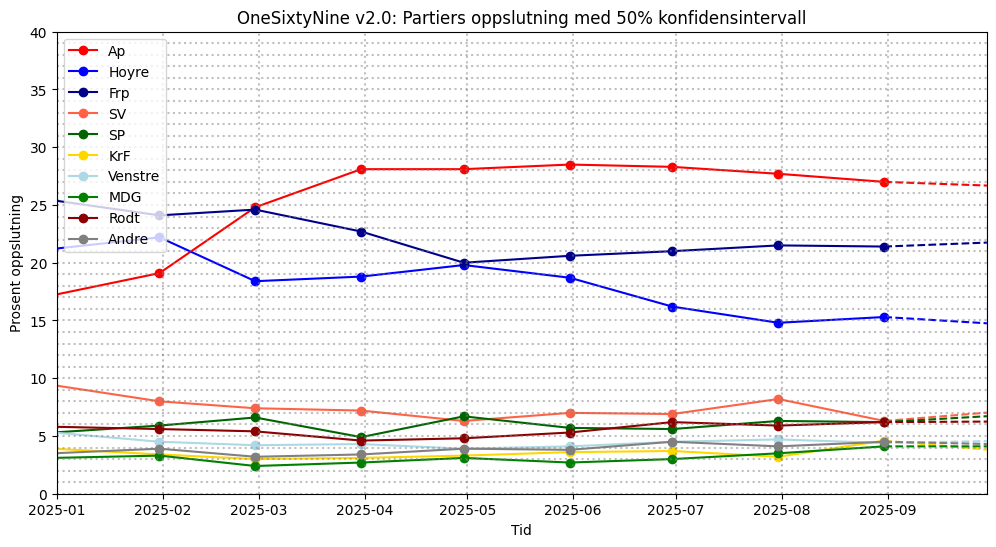

In [1301]:
# Define a color map for consistency
colors = {
    'Ap': '#FF0000',        # Red
    'Hoyre': '#0000FF',     # Blue
    'Frp': '#00008B',       # Dark Blue
    'SV': '#FF6347',        # Light Red (Tomato)
    'SP': '#006400',        # Dark Green
    'KrF': '#FFD700',       # Yellow (Gold)
    'Venstre': '#ADD8E6',   # Light Blue
    'MDG': '#008000',       # Green
    'Rodt': '#8B0000',      # Dark Red
    'Andre': '#808080'      # Gray
}

plt.figure(figsize=(12, 6))

for party in colors.keys():  # Iterate over defined parties
    color = colors[party]  

    # Plot actual data
    plt.plot(df_en.index, df_en[party], marker="o", color=color, label=f"{party}")

    # Plot forecast 
    plt.plot(forecast_df.index, forecast_df[party], linestyle="dashed", color=color)

    last_actual_date = df_en.index[-1]
    first_forecast_date = forecast_df.index[0]
    last_actual_value = df_en[party].iloc[-1]
    first_forecast_value = forecast_df[party].iloc[0]

    plt.plot([last_actual_date, first_forecast_date], [last_actual_value, first_forecast_value], color=color, linestyle="dashed")
    
    # Plot confidence interval (original scale)
    plt.fill_between(forecast_df.index, 
                     forecast_lower_df[party], 
                     forecast_upper_df[party], 
                     color=color, alpha=0.2)


dates = pd.date_range(start="2023-01-01", end="2025-09-30", freq="MS") 
for date in dates:
    plt.axvline(date, color="gray", linestyle="dotted", alpha=0.5)

# Add horizontal grid lines every 5%
for percent in range(0, 45, 1):
    plt.axhline(percent, color="gray", linestyle="dotted", alpha=0.5)

plt.xlim(np.datetime64("2025-01-01"), np.datetime64("2025-09-30"))  # Manually set max date to Sept 2025
plt.ylim(0,40)  # Manually set max date to Sept 2025
plt.xlabel("Tid")
plt.ylabel("Prosent oppslutning")
plt.title("OneSixtyNine v2.0: Partiers oppslutning med 50% konfidensintervall")
plt.legend(loc="upper left")
plt.show()

In [1302]:
forecast_df=forecast_df[['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']]
#forecast_df=(forecast_df.T / forecast_df.sum(axis=1) * 100).T
forecast_lower_df=forecast_lower_df[['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']]
forecast_upper_df=forecast_upper_df[['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']]

In [1303]:
###finn estimat for september
date_to_extract = "2025-09-30"

# Extract the row for the given date from each dataframe
estimate_row = forecast_df.loc[date_to_extract]
lower_row = forecast_lower_df.loc[date_to_extract]
upper_row = forecast_upper_df.loc[date_to_extract]

# Combine into a new DataFrame
result_df = pd.DataFrame({
    "Party": estimate_row.index,
    "Estimate": estimate_row.values,
    "Lower": lower_row.values,
    "Upper": upper_row.values
})

# Display the final structured DataFrame
result_df

,Party,Estimate,Lower,Upper
0,Ap,26.681689,24.325651,29.037728
1,Hoyre,14.754820,12.706225,16.803414
2,Frp,21.743398,19.822545,23.664251
3,SV,7.020273,6.262653,7.777892
4,SP,6.711496,5.237019,8.185972
5,KrF,3.813854,3.216503,4.411205
6,Venstre,4.556597,3.884359,5.228834
7,MDG,4.103204,3.541448,4.664960
8,Rodt,6.245367,5.503996,6.986737
9,Andre,4.304696,3.660205,4.949187


In [1304]:
# Multivariate MC!
n_sim = 100000
# Extract mean estimates (yhat) and covariance matrix
yhat_vector = result_df["Estimate"].values  # Mean estimates for all parties
#yhat_vector = df_orig.iloc[-1][['Ap','Hoyre','Frp','SV','SP','KrF','Venstre','MDG','Rodt','Andre']].values
cov_matrix = forecast_cov[-1]  # Covariance matrix at final step (latest forecast)
#cov_matrix_df = df_orig[['Ap','Hoyre','Frp','SV','SP','KrF','Venstre','MDG','Rodt','Andre']].cov()#.to_numpy()
#cov_matrix=cov_matrix_df.to_numpy()

# Convert to NumPy array
#W = cov_matrix.to_numpy()

# Generate correlated samples
samples = np.random.multivariate_normal(yhat_vector, cov_matrix, size=n_sim)
samples = np.maximum(samples, 1e-6) ##must be above 0
samples = (samples.T / samples.sum(axis=1) * 100).T

# Create a DataFrame with sampled values
sampled_df = pd.DataFrame(samples, columns=result_df["Party"])

# Compute vote totals for each simulation
red_green_votes = sampled_df[["Ap", "SV", "SP", "Rodt", "MDG"]].sum(axis=1)# /sampled_df.sum(axis=1)
blue_votes = sampled_df[["Hoyre", "Frp", "KrF", "Venstre"]].sum(axis=1)# /sampled_df.sum(axis=1)

# Probability that red-green block wins
prob_red_green_wins = np.mean(red_green_votes > blue_votes)

print(f"Sannsyn for at Ap+SV+Sp+R+MDG > H+FrP+KrF+V: {prob_red_green_wins:.4f}")


Sannsyn for at Ap+SV+Sp+R+MDG > H+FrP+KrF+V: 0.9809


In [1305]:
yhat_vector

array([26.68168945, 14.75481963, 21.74339819,  7.02027265,  6.71149563,
        3.81385389,  4.55659652,  4.10320395,  6.24536664,  4.30469613])

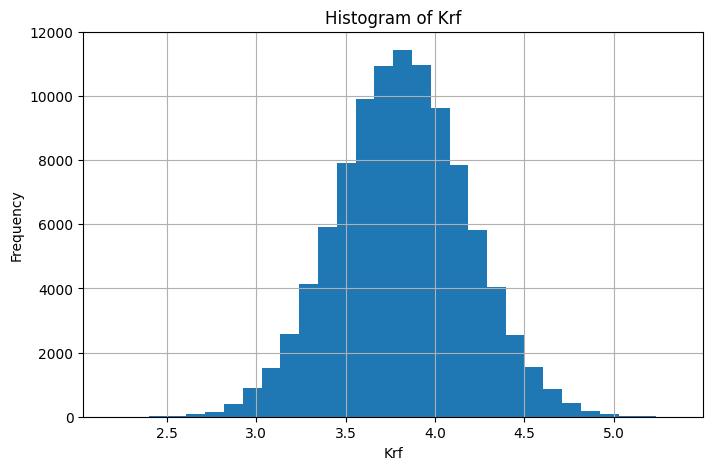

In [1306]:
sampled_df[['KrF']].hist(bins=30, figsize=(8, 5))
plt.xlabel('Krf')
plt.ylabel('Frequency')
plt.title('Histogram of Krf')
plt.show()

In [1307]:
yhat_vector

array([26.68168945, 14.75481963, 21.74339819,  7.02027265,  6.71149563,
        3.81385389,  4.55659652,  4.10320395,  6.24536664,  4.30469613])

In [1308]:
df_orig.iloc[-1][['Ap','Hoyre','Frp','SV','SP','KrF','Venstre','MDG','Rodt','Andre']].values

array([27. , 15.3, 21.4,  6.3,  6.2,  4.6,  4.4,  4.1,  6.2,  4.5])

In [1309]:
df_orig_p=df_orig[['Ap','Hoyre','Frp','SV','SP','KrF','Venstre','MDG','Rodt']]

In [1310]:
df_orig_p

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt
Mnd,,,,,,,,,
2008-06-30,26.0,17.6,28.9,6.9,5.3,6.1,5.9,0.0,1.8
2008-07-31,26.9,17.2,30.2,6.6,4.7,6.1,5.4,0.0,1.9
2008-08-31,26.6,16.2,30.9,6.7,5.2,5.5,6.0,0.0,1.7
2008-09-30,28.9,15.2,29.9,6.3,5.0,5.7,5.9,0.0,1.5
2008-10-31,30.6,16.1,26.7,7.3,5.3,5.6,5.5,0.0,1.2
...,...,...,...,...,...,...,...,...,...
2025-04-30,28.1,19.8,20.0,6.3,6.7,3.3,3.9,3.1,4.8
2025-05-31,28.5,18.7,20.6,7.0,5.7,3.6,4.1,2.7,5.3
2025-06-30,28.3,16.2,21.0,6.9,5.6,3.7,4.5,3.0,6.2


In [1311]:
sampled_df.drop(columns=["Andre"], inplace=True)

In [1312]:
yhat_vector

array([26.68168945, 14.75481963, 21.74339819,  7.02027265,  6.71149563,
        3.81385389,  4.55659652,  4.10320395,  6.24536664,  4.30469613])

In [1313]:
orig_mandate=pd.DataFrame(columns=df_orig.columns)

In [1314]:
sample_mandate=pd.DataFrame(columns=sampled_df.columns)

In [1315]:
def calc_mandat(oppslutt):
    if oppslutt <4.0:
        mandat=np.round(1/4*oppslutt**2,0)
    else: 
        oppslutt=round(1.8119*oppslutt,0)
    return int(oppslutt)

In [1316]:
for party in sampled_df.columns:
    sample_mandate[party]=sampled_df[party].apply(calc_mandat)

In [1317]:
for party in df_orig[['Ap','Hoyre','Frp','SV','SP','KrF','Venstre','MDG','Rodt']]:
    orig_mandate[party]=df_orig[party].apply(calc_mandat)

In [1318]:
orig_mandate

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Andre,...,Rodt_reg_lag3,Rodt_reg_lag6,Andre_reg_lag3,Andre_reg_lag6,ledighet,ledig_trend3,ledig_trend6,styringsrente,styringsrente_trend3,styringsrente_trend6
Mnd,,,,,,,,,,,,,,,,,,,,,
2008-06-30,47,32,52,13,10,11,11,0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-07-31,49,31,55,12,9,11,10,0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-08-31,48,29,56,12,9,10,11,0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-09-30,52,28,54,11,9,10,11,0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-10-31,55,29,48,13,10,10,10,0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-30,51,36,36,11,12,3,3,3,9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-05-31,52,34,37,13,10,3,7,2,10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-30,51,29,38,13,10,3,8,3,11,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1319]:
sample_mandate

Party,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt
0,48,25,43,12,15,2,8,8,11
1,44,32,37,13,12,3,9,3,12
2,50,30,34,13,13,8,8,8,11
3,47,26,37,13,12,3,9,8,13
4,51,26,39,12,12,3,8,3,12
...,...,...,...,...,...,...,...,...,...
99995,47,29,37,12,12,8,8,8,12
99996,49,30,39,11,10,7,8,8,12
99997,47,26,41,14,12,3,8,3,12
99998,47,27,39,12,12,7,9,8,12


In [1320]:
sample_mandate.to_csv('sample_august.csv')

In [1321]:
import numpy as np
import pandas as pd

#W = cov_matrix.to_numpy()[:9, :9]  # must be a numpy array
W = cov_matrix[:9, :9]
party_cols = ['Ap','Hoyre','Frp','SV','SP','KrF','Venstre','MDG','Rodt']
X = sample_mandate[party_cols].to_numpy()
one_vec = np.ones(len(party_cols))
W_inv = np.linalg.inv(W)

target_sum = 169
X_adj = []

for row in X:
    diff = target_sum - row.sum()
    # GLS adjustment (float)
    lambda_ = diff / (one_vec @ W_inv @ one_vec)
    adj_row = row + W_inv @ one_vec * lambda_

    # Convert to integers using largest remainder
    int_row = np.floor(adj_row).astype(int)
    remainder = int_row.sum()
    deficit = target_sum - remainder

    # Distribute remaining seats to largest fractional parts
    frac = adj_row - np.floor(adj_row)
    for i in np.argsort(-frac)[:deficit]:
        int_row[i] += 1

    X_adj.append(int_row)

# Replace with adjusted integer values
df_adj = sample_mandate.copy()
df_adj[party_cols] = X_adj
df_adj['Sum_adj'] = df_adj[party_cols].sum(axis=1)

#print(df_adj[['Sum_adj']].head())


In [1322]:
sample_169=df_adj

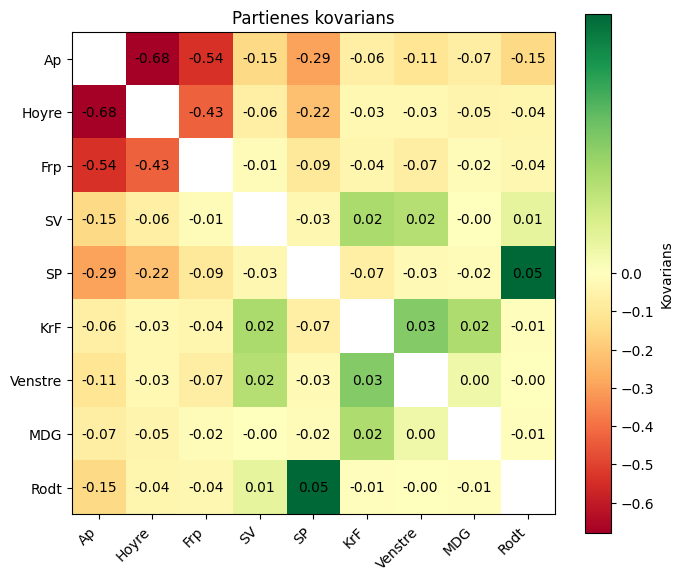

In [1323]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Party labels
labels = ['Ap','Hoyre','Frp','SV','SP','KrF','Venstre','MDG','Rodt']

# Mask diagonal to hide color
W_masked = W.copy()
np.fill_diagonal(W_masked, np.nan)

# Normalize colormap to center at zero
norm = mcolors.TwoSlopeNorm(vmin=np.nanmin(W_masked), vcenter=0, vmax=np.nanmax(W_masked))

plt.figure(figsize=(7, 6))
im = plt.imshow(W_masked, cmap='RdYlGn', norm=norm)
plt.colorbar(im, label='Kovarians')
plt.title('Partienes kovarians')

# Add numerical values for non-diagonal cells
for i in range(W.shape[0]):
    for j in range(W.shape[1]):
        if i != j:
            plt.text(j, i, f"{W[i, j]:.2f}", ha='center', va='center', color='black')

# Set axis ticks and labels
plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(labels)), labels=labels)

plt.grid(False)
plt.tight_layout()
plt.show()


In [1324]:
sample_169['rg'] = sample_169[["Ap", "SV", "SP", "Rodt", "MDG"]].sum(axis=1)

In [1325]:
sample_169['bb'] = sample_169[["Hoyre", "Frp", "Venstre", "KrF"]].sum(axis=1)

In [1326]:
sample_169

Party,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Sum_adj,rg,bb
0,48,25,43,11,15,2,7,7,11,169,92,77
1,44,32,37,14,12,4,10,4,12,169,86,83
2,49,30,34,12,13,7,7,7,10,169,91,78
3,47,26,37,13,12,3,9,9,13,169,94,75
4,51,26,39,13,12,3,9,4,12,169,92,77
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,47,29,37,11,12,7,7,7,12,169,89,80
99996,49,30,39,10,10,6,7,7,11,169,87,82
99997,47,26,41,15,12,3,9,4,12,169,90,79
99998,47,27,39,11,12,6,8,7,12,169,89,80


In [1327]:
sample_169['r_win'] = (sample_169['bb'] < sample_169['rg'])

In [1328]:
sample_169['r_win'].mean()

0.97172

In [1329]:
filtered = sample_169[(sample_169['MDG'] < 4) & (sample_169['KrF'] > 4) & (sample_169['Venstre'] > 4)]

# Calculate probability
prob = filtered['r_win'].mean()

print(f"Probability: {prob:.4f}")
print(f"Number of cases: {len(filtered)}")

Probability: 0.8215
Number of cases: 7478


In [1330]:
len(sample_169[sample_169['Rodt'] < 8])

2

In [1331]:
sample_169['red_green'] = sample_169[["Ap", "SV", "SP", "Rodt", "MDG"]].sum(axis=1)

In [1332]:
sample_169['red_green'] = sample_169[["Ap", "SV", "SP", "Rodt", "MDG"]].sum(axis=1)
sample_169['ap_sp'] = sample_169[["Ap", "SP"]].sum(axis=1)
sample_169['ap_sp_sv'] = sample_169[["Ap", "SP", "SV"]].sum(axis=1)
sample_169['ap_sp_sv_r'] = sample_169[["Ap", "SP", "SV", "Rodt"]].sum(axis=1)
sample_169['ap_sp_sv_r_mdg'] = sample_169[["Ap", "SP", "SV", "Rodt", "MDG"]].sum(axis=1)
sample_169['h_frp'] = sample_169[["Hoyre", "Frp"]].sum(axis=1)
sample_169['h_frp_v_krf'] = sample_169[["Hoyre", "Frp", "Venstre", "KrF"]].sum(axis=1)
sample_169['h_frp_v_krf_mdg'] = sample_169[["Hoyre", "Frp", "Venstre", "KrF", "MDG"]].sum(axis=1)

In [1333]:
sample_169['red_green_victory'] = sample_169['red_green'] >= 85
sample_169['ap_sp_victory'] = sample_169['ap_sp'] >= 85
sample_169['ap_sp_sv_victory'] = sample_169['ap_sp_sv'] >= 85
sample_169['ap_sp_sv_r'] = sample_169['ap_sp_sv_r'] >= 85
sample_169['ap_sp_sv_r_mdg'] = sample_169['ap_sp_sv_r_mdg'] >= 85
sample_169['h_frp'] = sample_169['h_frp'] >= 85
sample_169['h_frp_v_krf'] = sample_169['h_frp_v_krf'] >= 85
sample_169['h_frp_v_krf_mdg'] = sample_169['h_frp_v_krf_mdg'] >= 85

In [1334]:
sample_169['r_avh'] = (sample_169[["Ap", "SP", "SV"]].sum(axis=1) < 85) & (sample_169[["Ap", "SP", "SV", "Rodt"]].sum(axis=1)) >= 85

In [1335]:
sample_169['g_avh'] = (sample_169[["Ap", "SP", "SV", "Rodt"]].sum(axis=1) < 85) & (sample_169[["Ap", "SP", "SV", "Rodt", "MDG"]].sum(axis=1)) >= 85

In [1336]:
print(sample_169['red_green_victory'].mean())
print(sample_169['ap_sp_victory'].mean())
print(sample_169['ap_sp_sv_victory'].mean())
print(sample_169['ap_sp_sv_r'].mean())
print(sample_169['ap_sp_sv_r_mdg'].mean())
print(sample_169['h_frp'].mean())
print(sample_169['h_frp_v_krf'].mean())
print(sample_169['h_frp_v_krf_mdg'].mean())
print(sample_169['r_avh'].mean())
print(sample_169['g_avh'].mean())

0.97172
0.0
5e-05
0.5127
0.97172
0.0
0.02828
0.4873
0.0
0.0


In [1337]:
sample_169.to_csv('sample.csv')

In [1338]:
len(sample_169['rg'])

100000

In [1339]:
np.round(sample_169['rg'])

0        92
1        86
2        91
3        94
4        92
         ..
99995    89
99996    87
99997    90
99998    89
99999    87
Name: rg, Length: 100000, dtype: int64

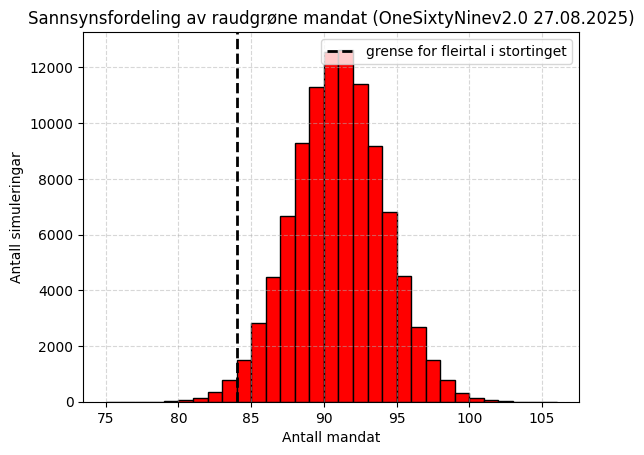

In [1340]:

plt.hist(
    sample_169['rg'],
    bins=range(75, sample_169['rg'].max() + 2),
    edgecolor='black',
    color='red'       # Set bar color to red
)
plt.axvline(
    x=84,
    color='black',
    linestyle='--',
    linewidth=2,
    label='grense for fleirtal i stortinget' # Optional label
)
plt.title('Sannsynsfordeling av raudgrøne mandat (OneSixtyNinev2.0 27.08.2025)')
plt.xlabel('Antall mandat')
plt.ylabel('Antall simuleringar')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

In [1341]:
last_actual_value

4.5

In [1342]:
last_fact=df_orig[df_orig.index=='2025-08-31'][['Ap','Hoyre','Frp','SV','SP','KrF','Venstre','MDG','Rodt']]

In [1343]:
last_fact

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt
Mnd,,,,,,,,,
2025-08-31,27.0,15.3,21.4,6.3,6.2,4.6,4.4,4.1,6.2


In [1344]:
last_mandate=pd.DataFrame(columns=last_fact.columns)

In [1345]:
for party in last_fact.columns:
    last_mandate[party]=last_fact[party].apply(calc_mandat)

In [1346]:
last_mandate

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt
Mnd,,,,,,,,,
2025-08-31,49,28,39,11,11,8,8,7,11


In [1347]:
last_mandate['Sum']=last_mandate.sum(axis=1)

In [1348]:
last_mandate

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Sum
Mnd,,,,,,,,,,
2025-08-31,49,28,39,11,11,8,8,7,11,172


In [1349]:
forecast_df

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Andre
2025-09-30,26.681689,14.75482,21.743398,7.020273,6.711496,3.813854,4.556597,4.103204,6.245367,4.304696


In [1350]:
forecast_df['Sum']=forecast_df.sum(axis=1)

In [1351]:
forecast_df

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Andre,Sum
2025-09-30,26.681689,14.75482,21.743398,7.020273,6.711496,3.813854,4.556597,4.103204,6.245367,4.304696,99.935393


In [1352]:
cov_matrix

array([[ 2.05168262e+00, -6.78701911e-01, -5.40385541e-01,
        -1.53385413e-01, -2.93153736e-01, -6.38567904e-02,
        -1.11019798e-01, -7.13267679e-02, -1.48926501e-01,
         1.38254579e-02],
       [-6.78701911e-01,  1.55116301e+00, -4.34032388e-01,
        -6.40242133e-02, -2.19994318e-01, -3.14490616e-02,
        -2.65926060e-02, -4.73097645e-02, -3.97476170e-02,
        -2.70279169e-03],
       [-5.40385541e-01, -4.34032388e-01,  1.36374721e+00,
        -1.33869770e-02, -9.15572401e-02, -3.90146905e-02,
        -7.04104911e-02, -1.58473285e-02, -3.61552993e-02,
        -1.06168835e-01],
       [-1.53385413e-01, -6.40242133e-02, -1.33869770e-02,
         2.12152334e-01, -3.28944817e-02,  1.98060203e-02,
         1.79604417e-02, -1.37156500e-03,  6.68068809e-03,
         5.81019668e-03],
       [-2.93153736e-01, -2.19994318e-01, -9.15572401e-02,
        -3.28944817e-02,  8.03565093e-01, -6.58221076e-02,
        -2.60745936e-02, -1.76069420e-02,  5.23490968e-02,
        -9.

In [1353]:
forecast

array([[-0.31831055, -0.54518037,  0.34339819,  0.72027265,  0.51149563,
        -0.78614611,  0.15659652,  0.00320395,  0.04536664, -0.19530387]])

In [1354]:
import numpy as np
from scipy.optimize import minimize

# example: estimates
parties = [c for c in forecast_df.columns if c != "Sum"]
e = forecast_df.loc["2025-09-30", parties].values


# weight matrix (identity for simple case)
W = cov_matrix

def objective(p):
    diff = p - e
    return diff @ W @ diff  # quadratic form

cons = [{'type': 'eq', 'fun': lambda p: np.sum(p) - 100}]
bounds = [(0, None)] * len(e)

res = minimize(objective, e, constraints=cons, bounds=bounds)
p_adj = res.x
print(p_adj)

[26.68815016 14.76128035 21.74985891  7.02673339  6.71795636  3.82031463
  4.56305726  4.10966469  6.25182738  4.31115687]


In [1355]:
p_adj

array([26.68815016, 14.76128035, 21.74985891,  7.02673339,  6.71795636,
        3.82031463,  4.56305726,  4.10966469,  6.25182738,  4.31115687])

In [1356]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

data=sampled_df[['KrF', 'Venstre', 'MDG']]

# Step 1: Calculate individual probabilities
individual_probabilities = {col: (data[col] >= 4.0).mean() for col in data.columns}

# Step 2: Calculate joint probabilities for combinations of 1 to 5 columns
joint_probabilities = {}
for r in range(1, len(data)):  
    for combo in combinations(data.columns, r):
        joint_condition = np.all(data[list(combo)] >= 4.0, axis=1)
        joint_probabilities[combo] = joint_condition.mean()




In [1357]:
individual_probabilities

{'KrF': 0.30731, 'Venstre': 0.91477, 'MDG': 0.61951}

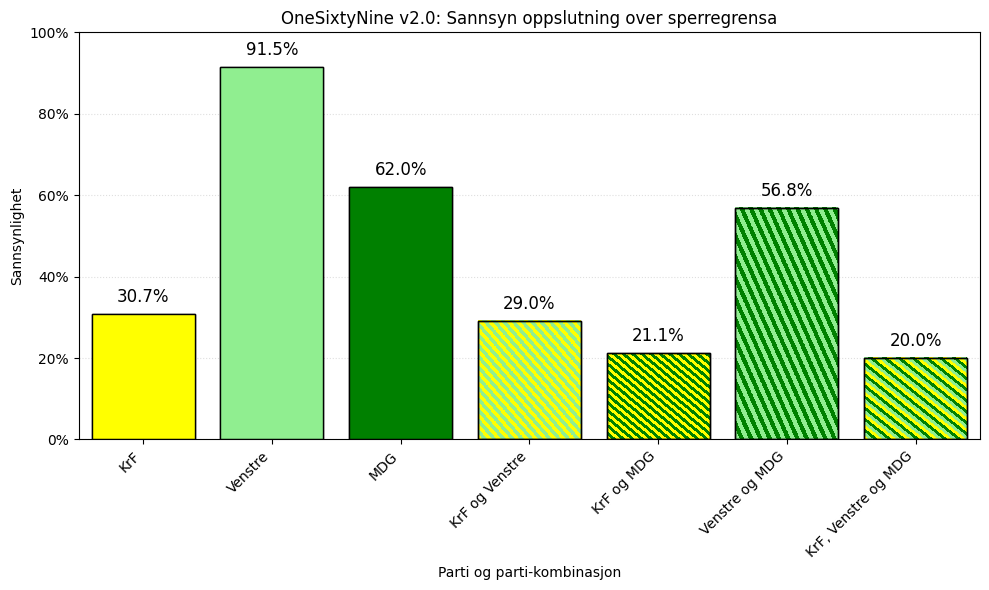

In [1358]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import to_rgb
from matplotlib.ticker import PercentFormatter

def combo_to_label(combo):
    combo = [str(c) for c in combo]  # konverter til str
    if len(combo) == 1:
        return combo[0]
    elif len(combo) == 2:
        return f'{combo[0]} og {combo[1]}'
    else:
        return f"{', '.join(combo[:-1])} og {combo[-1]}"

# Partifarger
party_colors = {'KrF': 'yellow', 'Venstre': 'lightgreen', 'MDG': 'green'}
rgb = {k: np.array(to_rgb(v)) for k, v in party_colors.items()}

x = np.arange(len(joint_probabilities))
vals = list(joint_probabilities.values())

fig, ax = plt.subplots(figsize=(10, 6))

# Justerbar stripebredde og oppløsning
stripe_px = 18   # piksler pr. stripe (mindre=tunnere striper)
size = 400       # høyere verdi = glattere diagonaler

for i, (combo, value) in enumerate(joint_probabilities.items()):
    if len(combo) == 1:
        ax.bar(i, value, color=party_colors[combo[0]], edgecolor='black', width=0.8, zorder=2)
    else:
        # Lag høytoppløst diagonalt mønster i 45°
        h = w = size
        yy, xx = np.mgrid[0:h, 0:w]
        idx = ((xx + yy) // stripe_px) % len(combo)

        pattern = np.zeros((h, w, 3), dtype=float)
        for j, party in enumerate(combo):
            pattern[idx == j] = rgb[party]

        ax.imshow(pattern,
                  extent=(i - 0.4, i + 0.4, 0, value),
                  origin='lower',
                  aspect='auto',
                  interpolation='nearest',
                  zorder=2)

        # Kantlinje rundt stolpen
        ax.add_patch(Rectangle((i - 0.4, 0), 0.8, value,
                               fill=False, edgecolor='black', linewidth=1, zorder=3))

for i, (combo, value) in enumerate(joint_probabilities.items()):
    if len(combo) == 1:
        ax.bar(i, value, color=party_colors[combo[0]], edgecolor='black', width=0.8, zorder=2)
        # Legg til verdi oppå stolpen
        ax.text(i, value + 0.02, f'{value*100:.1f}%', ha='center', va='bottom', fontsize=12, zorder=4)
    else:
        # Lag høytoppløst diagonalt mønster i 45°
        h = w = size
        yy, xx = np.mgrid[0:h, 0:w]
        idx = ((xx + yy) // stripe_px) % len(combo)

        pattern = np.zeros((h, w, 3), dtype=float)
        for j, party in enumerate(combo):
            pattern[idx == j] = rgb[party]

        ax.imshow(pattern,
                  extent=(i - 0.4, i + 0.4, 0, value),
                  origin='lower',
                  aspect='auto',
                  interpolation='nearest',
                  zorder=2)

        ax.add_patch(Rectangle((i - 0.4, 0), 0.8, value,
                               fill=False, edgecolor='black', linewidth=1, zorder=3))
        
        # Legg til verdi oppå stolpen
        ax.text(i, value + 0.02, f'{value*100:.1f}%', ha='center', va='bottom', fontsize=12, zorder=4)

ax.set_xticks(x)
#ax.set_xticklabels([str(c) for c in joint_probabilities.keys()], rotation=45, ha='right')
# Bruk funksjonen når du setter x-ticks
ax.set_xticklabels([combo_to_label(c) for c in joint_probabilities.keys()],
                   rotation=45, ha='right')
ax.set_title('OneSixtyNine v2.0: Sannsyn oppslutning over sperregrensa')
ax.set_xlabel('Parti og parti-kombinasjon')
ax.set_ylabel('Sannsynlighet')

# Fiks y-aksen: 0–100 % med prosentformat
ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.grid(axis='y', linestyle=':', alpha=0.4)
ax.set_xlim(-0.5, len(joint_probabilities) - 0.5)
plt.tight_layout()
plt.show()


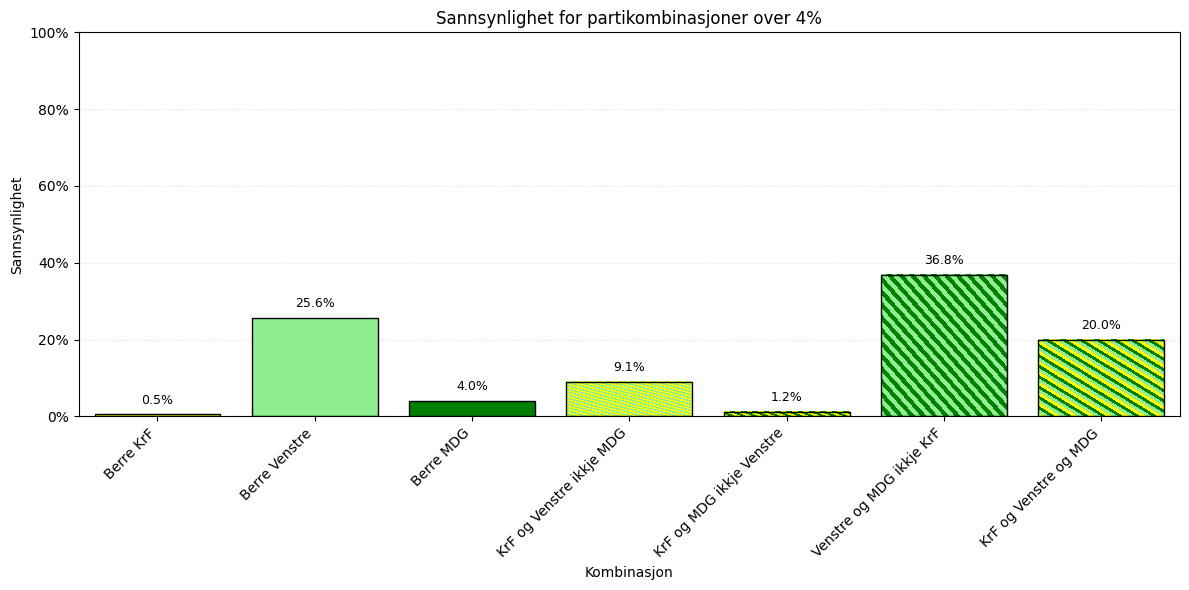

In [1363]:
joint_probabilities = {}
cols = data.columns.tolist()
n = len(cols)

for r in range(1, n + 1):
    for combo in combinations(cols, r):
        must_have = list(combo)
        must_not_have = [c for c in cols if c not in combo]

        condition = np.all(data[must_have] >= 4.0, axis=1)
        if must_not_have:
            condition &= np.all(data[must_not_have] < 4.0, axis=1)

        joint_probabilities[combo] = condition.mean()

# --- Funksjon for pene x-etiketter ---
def combo_to_label(combo):
    others = [c for c in data.columns if c not in combo]
    if len(combo) == 1:
        if others:
            return f'Berre {combo[0]}'
        else:
            return combo[0]
    else:
        label = ' og '.join(combo)
        if others:
            label += ' ikkje ' + ', '.join(others)
        return label

# --- Farger for partier ---
party_colors = {'KrF': 'yellow', 'Venstre': 'lightgreen', 'MDG': 'green'}
rgb = {k: np.array(to_rgb(v)) for k, v in party_colors.items()}

# --- Plotting ---
x = np.arange(len(joint_probabilities))
vals = list(joint_probabilities.values())

fig, ax = plt.subplots(figsize=(12, 6))

stripe_px = 18
size = 400

for i, (combo, value) in enumerate(joint_probabilities.items()):
    if len(combo) == 1:
        ax.bar(i, value, color=party_colors[combo[0]], edgecolor='black', width=0.8, zorder=2)
        ax.text(i, value + 0.02, f'{value*100:.1f}%', ha='center', va='bottom', fontsize=9, zorder=4)
    else:
        h = w = size
        yy, xx = np.mgrid[0:h, 0:w]
        idx = ((xx + yy) // stripe_px) % len(combo)

        pattern = np.zeros((h, w, 3), dtype=float)
        for j, party in enumerate(combo):
            pattern[idx == j] = rgb[party]

        ax.imshow(pattern,
                  extent=(i - 0.4, i + 0.4, 0, value),
                  origin='lower',
                  aspect='auto',
                  interpolation='nearest',
                  zorder=2)

        ax.add_patch(Rectangle((i - 0.4, 0), 0.8, value,
                               fill=False, edgecolor='black', linewidth=1, zorder=3))
        ax.text(i, value + 0.02, f'{value*100:.1f}%', ha='center', va='bottom', fontsize=9, zorder=4)

# X-akse med pene etiketter
ax.set_xticks(x)
ax.set_xticklabels([combo_to_label(c) for c in joint_probabilities.keys()],
                   rotation=45, ha='right')

ax.set_title('Sannsynlighet for partikombinasjoner over 4%')
ax.set_xlabel('Kombinasjon')
ax.set_ylabel('Sannsynlighet')

ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.grid(axis='y', linestyle=':', alpha=0.4)

ax.set_xlim(-0.5, len(joint_probabilities) - 0.5)  # Sørg for at første og siste stolpe vises helt

plt.tight_layout()
plt.show()

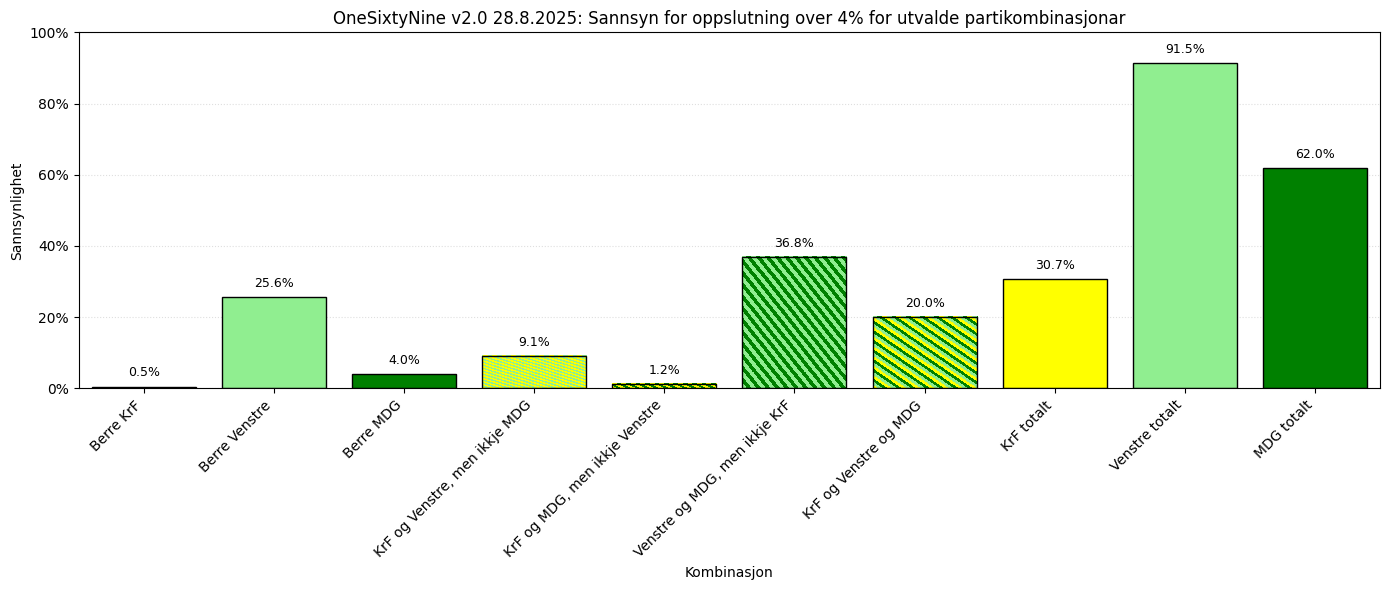

In [1366]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import to_rgb
from matplotlib.ticker import PercentFormatter
from itertools import combinations

# --- Eksempeldata (bruk din sampled_df) ---
# sampled_df = pd.DataFrame({
#     'KrF': np.random.uniform(0, 10, 1000),
#     'Venstre': np.random.uniform(0, 10, 1000),
#     'MDG': np.random.uniform(0, 10, 1000)
# })

data = sampled_df[['KrF', 'Venstre', 'MDG']]

# --- Beregn joint probabilities med "bare / ikke" logikk ---
joint_probabilities = {}
cols = data.columns.tolist()
n = len(cols)

for r in range(1, n + 1):
    for combo in combinations(cols, r):
        must_have = list(combo)
        must_not_have = [c for c in cols if c not in combo]

        condition = np.all(data[must_have] >= 4.0, axis=1)
        if must_not_have:
            condition &= np.all(data[must_not_have] < 4.0, axis=1)

        joint_probabilities[combo] = condition.mean()

# --- Beregn totals for hver enkelt parti ---
total_probabilities = {col: (data[col] >= 4.0).mean() for col in data.columns}
for col, prob in total_probabilities.items():
    joint_probabilities[(col, 'totalt')] = prob

# --- Funksjon for pene x-etiketter ---
def combo_to_label(combo):
    # Håndter totals
    if combo[-1] == 'totalt':
        return f'{combo[0]} totalt'
    
    others = [c for c in data.columns if c not in combo]
    if len(combo) == 1:
        if others:
            return f'Berre {combo[0]}'
        else:
            return combo[0]
    else:
        label = ' og '.join(combo)
        if others:
            label += ', men ikkje ' + ', '.join(others)
        return label

# --- Farger for partier ---
party_colors = {'KrF': 'yellow', 'Venstre': 'lightgreen', 'MDG': 'green'}
rgb = {k: np.array(to_rgb(v)) for k, v in party_colors.items()}

# --- Plotting ---
x = np.arange(len(joint_probabilities))
vals = list(joint_probabilities.values())

fig, ax = plt.subplots(figsize=(14, 6))

stripe_px = 18
size = 400

for i, (combo, value) in enumerate(joint_probabilities.items()):
    # Totals kan vises med solid farge (velg første parti i tuple)
    if combo[-1] == 'totalt':
        ax.bar(i, value, color=party_colors[combo[0]], edgecolor='black', width=0.8, zorder=2)
        ax.text(i, value + 0.02, f'{value*100:.1f}%', ha='center', va='bottom', fontsize=9, zorder=4)
    elif len(combo) == 1:
        ax.bar(i, value, color=party_colors[combo[0]], edgecolor='black', width=0.8, zorder=2)
        ax.text(i, value + 0.02, f'{value*100:.1f}%', ha='center', va='bottom', fontsize=9, zorder=4)
    else:
        # Diagonalstripe for kombinasjoner
        h = w = size
        yy, xx = np.mgrid[0:h, 0:w]
        idx = ((xx + yy) // stripe_px) % len(combo)

        pattern = np.zeros((h, w, 3), dtype=float)
        for j, party in enumerate(combo):
            pattern[idx == j] = rgb[party]

        ax.imshow(pattern,
                  extent=(i - 0.4, i + 0.4, 0, value),
                  origin='lower',
                  aspect='auto',
                  interpolation='nearest',
                  zorder=2)

        ax.add_patch(Rectangle((i - 0.4, 0), 0.8, value,
                               fill=False, edgecolor='black', linewidth=1, zorder=3))
        ax.text(i, value + 0.02, f'{value*100:.1f}%', ha='center', va='bottom', fontsize=9, zorder=4)

# X-akse med pene etiketter
ax.set_xticks(x)
ax.set_xticklabels([combo_to_label(c) for c in joint_probabilities.keys()],
                   rotation=45, ha='right')

ax.set_title('OneSixtyNine v2.0 28.8.2025: Sannsyn for oppslutning over 4% for utvalde partikombinasjonar')
ax.set_xlabel('Kombinasjon')
ax.set_ylabel('Sannsynlighet')

ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.grid(axis='y', linestyle=':', alpha=0.4)

ax.set_xlim(-0.5, len(joint_probabilities) - 0.5)  # Sørg for at første og siste stolpe vises helt

plt.tight_layout()
plt.show()


In [1385]:
p1=2/3
seq= np.random.choice([0,1], p=[1-p1, p1], size=10000)

In [1387]:
seq

array([1, 1, 1, ..., 0, 1, 1])

In [1377]:
seq_str= ''.join(map(str, seq))

In [1402]:
seq_str.count('0111110')

125

In [1388]:
sum(seq)/len(seq)

0.6721

In [1389]:
seq_str.count('11111')

490

In [1390]:
10000*(2/3)**5

1316.8724279835387

SyntaxError: invalid character '–' (U+2013) (4169448567.py, line 31)